# NiWrap and Connectome Workbench
## Surface-Based Visualization Workflow for Single-Subject CIFTI

####
**Author**: Monika Doerig

**Date**: 23 July 2025

### Citation and Resources:

#### Tools included in this workflow
__NiWrap:__

```python
@software{niwrap,
  author = {The NiWrap Contributors},
  title = {NiWrap: Type-Safe Neuroimaging Tool Wrappers},
  url = {https://github.com/styx-api/niwrap},
  note = {Preprint in preparation},
  year = {2025}
```
- [https://github.com/styx-api/niwrap](https://github.com/styx-api/niwrap)
- [Documentation](https://styx-api.github.io/styxbook/)

__Connectome Workbench:__
- Marcus, D. S., Harwell, J., Olsen, T., Hodge, M., Glasser, M. F., Prior, F., Jenkinson, M., Laumann, T., Curtiss, S. W., & Van Essen, D. C. (2011). Informatics and data mining tools and strategies for the human connectome project. Frontiers in neuroinformatics, 5, 4. [https://doi.org/10.3389/fninf.2011.00004](https://doi.org/10.3389/fninf.2011.00004)
- [Workbench Command Documentation](https://www.humanconnectome.org/software/workbench-command)


#### Dataset
- Zhengxin Gong and Ming Zhou and Yuxuan Dai and Yushan Wen and Youyi Liu and Zonglei Zhen (2023). A large-scale fMRI dataset for the visual processing of naturalistic scenes. OpenNeuro. [Dataset] doi: [doi:10.18112/openneuro.ds004496.v2.1.2](https://openneuro.org/datasets/ds004496/versions/2.1.2)

## Load software tools and import python libraries

In [1]:
# Load connectomeworkbench
import module
await module.load('connectomeworkbench/1.5.0')
await module.list()

['connectomeworkbench/1.5.0']

In [2]:
%%capture 
!pip install niwrap==0.6.1 nilearn==0.12.0 nibabel==5.3.2 pandas==2.2.3

In [3]:
# Import the necessary libraries

import matplotlib.pyplot as plt 
import os 
from pathlib import Path
from niwrap_workbench.workbench import (cifti_math, cifti_math_var_params, cifti_separate, cifti_separate_metric_params, 
                                        cifti_stats, metric_smoothing, cifti_create_dense_scalar, cifti_create_dense_scalar_left_metric_params, cifti_create_dense_scalar_right_metric_params,
                                        cifti_parcellate, file_information, cifti_label_export_table)
import re
import pandas as pd
from nilearn import plotting, surface
import nibabel as nib
import numpy as np

## Data download and preparation
### Datalad

In [4]:
%%bash
# --- Configuration ---
REPO_URL="https://github.com/OpenNeuroDatasets/ds004496.git"
DATASET_DIR="ds004496"
SUBJECT_ID="sub-01"

# --- Datalad Installation ---
if [ ! -d "$DATASET_DIR" ]; then
  datalad install $REPO_URL
else
  echo "Dataset directory '$DATASET_DIR' already exists. Skipping install."
fi

cd $DATASET_DIR

# --- Datalad Data Download ---
echo "Downloading Ciftify derivative files for $SUBJECT_ID from ds004496..."

# 1. Get the beta map from the floc task.
datalad get "derivatives/ciftify/$SUBJECT_ID/results/ses-floc_task-floc/ses-floc_task-floc_beta.dscalar.nii"

# 2. Get the corresponding T1 surface geometry files.
#datalad get "derivatives/ciftify/$SUBJECT_ID/T1w_fsLR_surface"

# 2. Get the corresponding standard surface geometry files.
datalad get "derivatives/ciftify/$SUBJECT_ID/standard_fsLR_surface"

echo "Datalad download complete for ds004496."


[INFO] Attempting a clone into /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/ds004496 
[INFO] Attempting to clone from https://github.com/OpenNeuroDatasets/ds004496.git to /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/ds004496 
[INFO] Start enumerating objects 
[INFO] Start counting objects 
[INFO] Start compressing objects 
[INFO] Start receiving objects 
[INFO] Start resolving deltas 
[INFO] Completed clone attempts for Dataset(/home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/ds004496) 
[INFO] scanning for unlocked files (this may take some time) 
[INFO] Remote origin not usable by git-annex; setting annex-ignore 


install(ok): /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/ds004496 (dataset)
get(ok): derivatives/ciftify/sub-01/results/ses-floc_task-floc/ses-floc_task-floc_beta.dscalar.nii (file)
get(ok): derivatives/ciftify/sub-01/standard_fsLR_surface/sub-01.ArealDistortion_FS.32k_fs_LR.dscalar.nii (file)
get(ok): derivatives/ciftify/sub-01/standard_fsLR_surface/sub-01.ArealDistortion_MSMSulc.32k_fs_LR.dscalar.nii (file)
get(ok): derivatives/ciftify/sub-01/standard_fsLR_surface/sub-01.BA_exvivo.32k_fs_LR.dlabel.nii (file)
get(ok): derivatives/ciftify/sub-01/standard_fsLR_surface/sub-01.EdgeDistortion_MSMSulc.32k_fs_LR.dscalar.nii (file)
get(ok): derivatives/ciftify/sub-01/standard_fsLR_surface/sub-01.L.inflated.32k_fs_LR.surf.gii (file)
get(ok): derivatives/ciftify/sub-01/standard_fsLR_surface/sub-01.L.midthickness.32k_fs_LR.surf.gii (file)
get(ok): derivatives/ciftify/sub-01/standard_fsLR_surface/sub-01.L.pial.32k_fs_LR.surf.gii (file)
get(ok): derivatives/ciftify/sub-01/s

In [5]:
# --- Define File Paths ---
DATASET_DIR = Path("ds004496")
SUBJECT_ID = "sub-01"

# The root directory of the Ciftify derivatives
deriv_dir = DATASET_DIR / "derivatives" / "ciftify"

# 1. Input File: The statistical map
beta_map_path = (
    deriv_dir
    / SUBJECT_ID
    / "results"
    / "ses-floc_task-floc"
    / "ses-floc_task-floc_beta.dscalar.nii"
)

# 2. Input Files: The surface geometry files.
surface_dir = deriv_dir / SUBJECT_ID / "standard_fsLR_surface"
left_surf_path = surface_dir / f"{SUBJECT_ID}.L.midthickness.32k_fs_LR.surf.gii"
right_surf_path = surface_dir / f"{SUBJECT_ID}.R.midthickness.32k_fs_LR.surf.gii"
left_infl_path = surface_dir / f"{SUBJECT_ID}.L.inflated.32k_fs_LR.surf.gii"
right_infl_path = surface_dir / f"{SUBJECT_ID}.R.inflated.32k_fs_LR.surf.gii"
sulcal_depth_path = surface_dir / f"{SUBJECT_ID}.sulc.32k_fs_LR.dscalar.nii"


# --- Verify files exist before we start ---
assert left_surf_path.exists(), f"Left mid-surface not found: {left_surf_path}"
assert right_surf_path.exists(), f"Right mid-surface not found: {right_surf_path}"
assert left_infl_path.exists(), f"Left inflated surface not found: {left_surf_path}"
assert right_infl_path.exists(), f"Right inflated surface not found: {right_surf_path}"
assert sulcal_depth_path.exists(), f"Sulcal depth not found: {sulcal_depth_path}"
print("✅ All necessary files found. Ready for analysis.")


✅ All necessary files found. Ready for analysis.


In [6]:
# Download Schaefer atlas (skip if exists)
! wget -nc -q --show-progress https://github.com/ThomasYeoLab/CBIG/raw/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/HCP/fslr32k/cifti/Schaefer2018_400Parcels_17Networks_order.dlabel.nii

Schaefer2018_400Par 100%[===================>] 667.06K  --.-KB/s    in 0.04s   


## Surface-Based Visualization Workflow
This workflow demonstrates a surface-based approach for processing and visualizing single-subject CIFTI contrast data using `niwrap` and `Connectome Workbench`. These cifti files consist of 91,282 grayordinates: 32,492 cortical vertices per hemisphere and 26,298 subcortical voxels with approximately 2 mm spatial resolution. In this notebook we are focusing on the cortical vertices.
The goal is to showcase how multi-contrast CIFTI data can be extracted, thresholded, separated by hemisphere, smoothed, and parcellated for comprehensive visualization and analysis on the cortical surface.

⚠️ **Important Note**: This tutorial uses `niwrap`, which at the time of creating this example is in early release stage. It is not recommended for production use unless you are willing to debug, fix, and contribute descriptors. Due to version compatibility issues between `niwrap` and different Connectome Workbench installations, some steps in this workflow fall back to direct `wb_command` calls where `niwrap` functions were not compatible with the available Workbench version.

Therefore, this example is not intended for statistical inference but serves to demonstrate how `niwrap` can be used alongside `Connectome Workbench` for surface-based processing and visualization. The selected steps highlight a practical path for extracting, thresholding, separating, and smoothing single-subject contrast data to create interpretable visual outputs:

1. Split Maps
2. Thresholding
3. Surface Separation
4. Sulcal Depth Separation
5. Statistical Summary
6. Surface Smoothing
7. Parcellation

### 1. Split Maps
A multi-map statistical image containing 5 different contrast maps is separated into individual maps using *wb_command* `-cifti-merge`. In this example, the "Face - others" contrast (column 3) is extracted from the original multi-map CIFTI file to create a single contrast map for focused analysis and visualization.

In [7]:
#create output directory
output_dir = Path("./niwrap_results").absolute()
output_dir.mkdir(parents=True, exist_ok=True)

*Note: These steps use direct `wb_command` due to compatibility issues with the current `niwrap` implementation.*

In [8]:
! wb_command -file-information $beta_map_path -only-map-names

Character - others
Body - others
Face - others
Place - others
Object - others


In [9]:
! wb_command -cifti-merge ./niwrap_results/beta_face.dscalar.nii -cifti $beta_map_path -column 3

In [10]:
! wb_command -file-information ./niwrap_results/beta_face.dscalar.nii -only-map-names

Face - others


### 2. Thresholding a CIFTI map - `cifti_math`
The "Face - others" contrast map is thresholded using a data-driven approach rather than a fixed value. The 95th percentile of non-NaN values is computed and used as the threshold, retaining only the strongest contrast values while preserving their original magnitudes (rather than creating a binary mask). This approach adapts to the actual data distribution and highlights the top 5% of contrast values.

In [11]:
# Load the beta map
img = nib.load("./niwrap_results/beta_face.dscalar.nii")
data = img.get_fdata()

# Mask out NaNs (some CIFTI data may have them)
masked_data = data[~np.isnan(data)]

# Compute 95th percentile
percentile_95 = np.percentile(masked_data, 95)

print(f"95th percentile value: {percentile_95}")

95th percentile value: 1.081139940023422


In [12]:
output_file = output_dir / "beta_face_thresholded.dscalar.nii"

result_cifti = cifti_math(
    expression=f"x * (x > {percentile_95})",  # Retain original values > 95th percentile
    cifti_out=str(output_file),
    var=[
        cifti_math_var_params(
            name="x",
            cifti=str("./niwrap_results/beta_face.dscalar.nii")
        )
    ]
)

[D] Running command: wb_command -cifti-math 'x * (x > 1.081139940023422)' /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/beta_face_thresholded.dscalar.nii -var x /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/beta_face.dscalar.nii
[I] parsed 'x * (x > 1.081139940023422)' as 'x * (x > 1.08113994002342)'
[I] Executed cifti-math in 0:00:00.251962


### 3. Surface separation - `cifti_separate`
The thresholded CIFTI map is separated into left and right hemisphere GIFTI metric files. This step allows independent processing and visualization of each cortical hemisphere using standard surface templates.

In [13]:
metric = [
    cifti_separate_metric_params(
        structure="CORTEX_LEFT",
        metric_out=str(output_dir / "sub-01_thresh_lh.func.gii"),
    ),
    cifti_separate_metric_params(
        structure="CORTEX_RIGHT",
        metric_out=str(output_dir / "sub-01_thresh_rh.func.gii"),
    )
]

result_separate = cifti_separate(
    cifti_in=str(result_cifti.cifti_out), #thresholded image
    direction="COLUMN",
    metric=metric
)

[D] Running command: wb_command -cifti-separate /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/beta_face_thresholded.dscalar.nii COLUMN -metric CORTEX_LEFT /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/sub-01_thresh_lh.func.gii -metric CORTEX_RIGHT /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/sub-01_thresh_rh.func.gii
[I] Executed cifti-separate in 0:00:00.192519


### 4. Sulcal Depth Separation

A sulcal depth map in CIFTI format is split into left and right hemisphere GIFTI metric files. These depth maps are used as anatomical underlays to provide context for the overlaid activation maps during surface visualization.

In [14]:
metric = [
    cifti_separate_metric_params(
        structure="CORTEX_LEFT",
        metric_out=str(output_dir / "sub-01.L.sulc.func.gii"),
    ),
    cifti_separate_metric_params(
        structure="CORTEX_RIGHT",
        metric_out=str(output_dir / "sub-01.R.sulc.func.gii"),
    )
]

result_separate_sulc = cifti_separate(
    cifti_in=str(sulcal_depth_path),
    direction="COLUMN",
    metric=metric
)


[D] Running command: wb_command -cifti-separate /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/ds004496/derivatives/ciftify/sub-01/standard_fsLR_surface/sub-01.sulc.32k_fs_LR.dscalar.nii COLUMN -metric CORTEX_LEFT /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/sub-01.L.sulc.func.gii -metric CORTEX_RIGHT /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/sub-01.R.sulc.func.gii
[I] Executed cifti-separate in 0:00:00.195140


#### Surface Plotting with Nilearn
##### 1. Interactive Visualization with `view_surf` 

In [15]:
# Plot thresholde maps on cortical surfaces with interactive rotation and zooming

# Load meshes and concatenate coordinates
mesh_lh = surface.load_surf_mesh(str(left_surf_path))
mesh_rh = surface.load_surf_mesh(str(right_surf_path))
coords_combined = np.vstack([mesh_lh.coordinates, mesh_rh.coordinates])

# Offset RH face indices by LH vertex count
offset = mesh_lh.coordinates.shape[0]
faces_rh_offset = mesh_rh.faces + offset

# Concatenate faces
faces_combined = np.vstack([mesh_lh.faces, faces_rh_offset])

# Combine into mesh tuple
combined_mesh_mid = (coords_combined, faces_combined)

# Load and concatenate data
data_lh = nib.load(str(result_separate.metric[0].metric_out)).darrays[0].data
data_rh = nib.load(str(result_separate.metric[1].metric_out)).darrays[0].data
data_combined = np.concatenate([data_lh, data_rh])

# Plot both hemispheres
view = plotting.view_surf(
    surf_mesh=combined_mesh_mid,
    surf_map=data_combined,
    hemi='both',
    threshold=0.0001, #for better contrast of the brain surface
    title="Face > Others: fLoc Functional Localizer Results (Top 5% Activation)",
    title_fontsize=18,
    colorbar=False,
    darkness=None,   
)

view  

##### 2. Static Visualization with `plot_surf_stat_map` on inflated surface with sulcal depth background

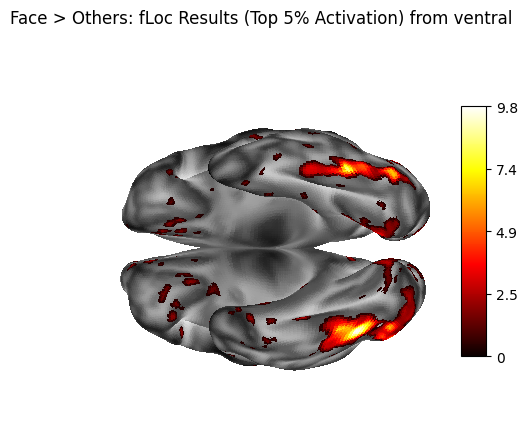

In [16]:
#inflated surface
infl_mesh_lh = surface.load_surf_mesh(str(left_infl_path))
infl_mesh_rh = surface.load_surf_mesh(str(right_infl_path))
coords_infl_combined = np.vstack([infl_mesh_lh.coordinates, infl_mesh_rh.coordinates])

facesinfl_rh_offset = infl_mesh_rh.faces + infl_mesh_lh.coordinates.shape[0]
faces_infl_combined = np.vstack([infl_mesh_lh.faces, facesinfl_rh_offset])
combined_infl_mesh = (coords_infl_combined, faces_infl_combined)

#sulcal depth background for anatomical context
sulc_lh = nib.load(str(result_separate_sulc.metric[0].metric_out)).darrays[0].data
sulc_rh = nib.load(str(result_separate_sulc.metric[1].metric_out)).darrays[0].data
sulc_combined = np.concatenate([sulc_lh, sulc_rh])


fig = plotting.plot_surf_stat_map(
    surf_mesh=combined_infl_mesh,
    stat_map=data_combined,
    hemi='both',
    title="Face > Others: fLoc Results (Top 5% Activation) from ventral",
    colorbar=True,
    darkness=None,
    threshold=0.0001,
    bg_map=sulc_combined,
    view='ventral',
    cmap='hot'
)
fig.show()

### 5. Statistical Summary - `cifti_stats`

The number of non-zero vertices in the thresholded data is counted to give a basic indication of how widespread the supra-threshold signal is across the cortical surface. This helps quantify the spatial extent of the contrast effect.

In [17]:
result_stats = cifti_stats(
    cifti_in=str(result_cifti.cifti_out),
    opt_reduce_operation="COUNT_NONZERO",
    opt_show_map_name=True
)

[D] Running command: wb_command -cifti-stats /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/beta_face_thresholded.dscalar.nii -reduce COUNT_NONZERO -show-map-name
[I] 1:	Face - others:	2971
[I] Executed cifti-stats in 0:00:00.186400


### 6. Surface Smoothing - `metric_smoothing`
A 2mm FWHM Gaussian kernel is applied to the hemisphere-separated thresholded metric files. Smoothing is often used to improve visualization by reducing noise and enhancing spatial coherence of the surface data. Here, the smoothed data will only be plotted for comparison purposes.

In [18]:
# Left hemisphere
smoothed_lh = output_dir / "sub-01_thresh_smooth.L.func.gii"

smooth_left = metric_smoothing(
    surface=str(left_surf_path),
    metric_in=str(result_separate.metric[0].metric_out),
    smoothing_kernel=2.0,
    metric_out=str(smoothed_lh),
)

# Right hemisphere
smoothed_rh = output_dir / "sub-01_thresh_smooth.R.func.gii"

smooth_right = metric_smoothing(
    surface=str(right_surf_path),
    metric_in=str(result_separate.metric[1].metric_out),
    smoothing_kernel=2.0,
    metric_out=str(smoothed_rh),
)

[D] Running command: wb_command -metric-smoothing /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/ds004496/derivatives/ciftify/sub-01/standard_fsLR_surface/sub-01.L.midthickness.32k_fs_LR.surf.gii /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/sub-01_thresh_lh.func.gii 2.0 /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/sub-01_thresh_smooth.L.func.gii
[I] Executed metric-smoothing in 0:00:00.415578
[D] Running command: wb_command -metric-smoothing /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/ds004496/derivatives/ciftify/sub-01/standard_fsLR_surface/sub-01.R.midthickness.32k_fs_LR.surf.gii /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/sub-01_thresh_rh.func.gii 2.0 /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/sub-01_thresh_smooth.R.func.gii
[I] Executed metric-smoothing in 0:00:00.438166


#### Visualization of the smoothed map

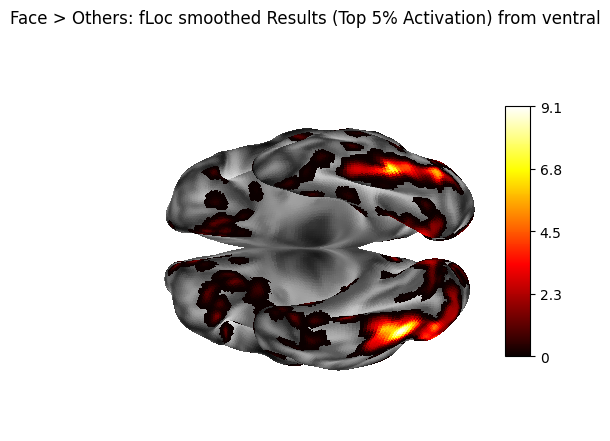

In [19]:
# Load and concatenate smoothed data
data_lh_smooth = nib.load(str(smoothed_lh)).darrays[0].data
data_rh_smooth = nib.load(str(smoothed_rh)).darrays[0].data
data_smooth = np.concatenate([data_lh_smooth, data_rh_smooth])


fig = plotting.plot_surf_stat_map(
    surf_mesh=combined_infl_mesh,
    stat_map=data_smooth,
    hemi='both',
    title="Face > Others: fLoc smoothed Results (Top 5% Activation) from ventral",
    colorbar=True,
    darkness=None,
    threshold=0.0001,
    bg_map=sulc_combined,
    view='ventral',
    cmap='hot',
)
fig.show()

### 7. Parcellation

The unsmoothed thresholded CIFTI file (.dscalar.nii) is parcellated using the Schaefer 400-region, 17-network functional atlas. This parcellation process averages the surface activation values within each predefined region, transforming dense vertex-wise maps (∼64k vertices) into compact, interpretable regional summaries (400 parcels). The resulting parcellated data enables network-level analysis and region-of-interest comparisons, while the exported parcellation labels provide anatomical context for interpreting the results.

In [20]:
parcellated = output_dir / "sub-01_parcellated.pscalar.nii"

result_parc = cifti_parcellate(
    cifti_in=result_cifti.cifti_out,
    cifti_label="Schaefer2018_400Parcels_17Networks_order.dlabel.nii",
    direction="COLUMN",
    cifti_out=str(parcellated)
)


[D] Running command: wb_command -cifti-parcellate /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/beta_face_thresholded.dscalar.nii /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/Schaefer2018_400Parcels_17Networks_order.dlabel.nii COLUMN /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/sub-01_parcellated.pscalar.nii
[I] Executed cifti-parcellate in 0:00:00.254114


In [21]:
export_table = cifti_label_export_table(
	label_in= str("./Schaefer2018_400Parcels_17Networks_order.dlabel.nii"),
    map_="parcels", 
	table_out= str(output_dir / "schaefer_labels.txt")
)

[D] Running command: wb_command -cifti-label-export-table /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/Schaefer2018_400Parcels_17Networks_order.dlabel.nii parcels /home/jovyan/Git_repositories/neurodeskedu/books/functional_imaging/niwrap_results/schaefer_labels.txt
[I] Executed cifti-label-export-table in 0:00:00.181663


#### Parcellated results
The parcellated results are visualized to identify regions with the strongest "Face > Others" contrast effects. First, the Schaefer atlas labels are parsed from the exported text file to create a lookup table linking parcel indices to anatomical region names and color information. The parcellated contrast values are then plotted as a bar chart showing all 400 regions. Additionally, a focused visualization displays the top 10 regions with their anatomical labels for easier interpretation of which brain areas show the strongest face-selective responses.

#### Get Schefer atlas labels and colors

In [22]:
label_file = "./niwrap_results/schaefer_labels.txt"

with open(label_file, 'r') as f:
    lines = [line.strip() for line in f if line.strip()]

# Separate odd and even lines
names = lines[0::2]   # 0, 2, 4 ... parcel names
colors = lines[1::2]  # 1, 3, 5 ... indices and RGB info

# Parse colors info lines into components
indices = []
Rs, Gs, Bs, As = [], [], [], []

for c in colors:
    # Split by whitespace
    parts = re.split(r'\s+', c)
    # First part is index, next are RGBA
    indices.append(int(parts[0]))
    Rs.append(float(parts[1]))
    Gs.append(float(parts[2]))
    Bs.append(float(parts[3]))
    As.append(float(parts[4]) if len(parts) > 4 else None)



df_labels = pd.DataFrame({
    'Index': indices,
    'Name': names,
    'R': Rs,
    'G': Gs,
    'B': Bs,
    'A': As
})

df_labels.head()

Index                           Name      R     G      B      A
0      1  17Networks_LH_VisCent_ExStr_1  120.0  18.0  131.0  255.0
1      2  17Networks_LH_VisCent_ExStr_2  120.0  18.0  132.0  255.0
2      3  17Networks_LH_VisCent_ExStr_3  120.0  18.0  133.0  255.0
3      4  17Networks_LH_VisCent_ExStr_4  120.0  18.0  134.0  255.0
4      5  17Networks_LH_VisCent_ExStr_5  120.0  18.0  136.0  255.0

#### Load parcellated activation data

In [23]:
img = nib.load(result_parc.cifti_out)  # .dscalar.nii file
data = img.get_fdata()  # shape should be (1, 400) 
# Squeeze to remove singleton dimensions
parcel_values = np.squeeze(data)

# Show how many parcels were activated
print(f"Number of parcels with positive activation: {np.sum(parcel_values > 0)}/400")

Number of parcels with positive activation: 182/400


#### Extract network information for visualization

In [24]:
# Extract names of parcels
def get_parcel_name(i, df_labels):
    """Extract Schaefer parcel name"""
    # i is zero-based index (0..399)
    # df_labels['Index'] is 1-based parcel ID
    parcel_id = i + 1
    # lookup the row where Index == parcel_id
    row = df_labels[df_labels['Index'] == parcel_id]
    if not row.empty:
        return row.iloc[0]['Name']
    else:
        print(f"Warning: Missing parcel {parcel_id}")
        return f"Parcel {parcel_id} (missing)"


# Extract unique network names for color coding
def extract_network(name):
    """Extract network name from Schaefer parcel name"""
    try:
        if '17Networks' in name:
            parts = name.split('_')
            if len(parts) >= 3:
                return parts[2]  # Network name
        return 'Unknown'
    except Exception as e:
        print(f"Warning: Failed to parse network from {name}: {e}")
        return 'Unknown'

# Get network names for all parcels
parcel_names = [get_parcel_name(i, df_labels) for i in range(400)]
networks = [extract_network(name) for name in parcel_names]
unique_networks = list(set(networks))

print(f"Found networks: {unique_networks}")

Found networks: ['LimbicB', 'LimbicA', 'ContB', 'VisCent', 'ContA', 'SalVentAttnB', 'ContC', 'DefaultC', 'SalVentAttnA', 'SomMotA', 'DefaultB', 'DorsAttnB', 'DorsAttnA', 'SomMotB', 'TempPar', 'DefaultA', 'VisPeri']


#### Create network-colored bar plot of all parcels

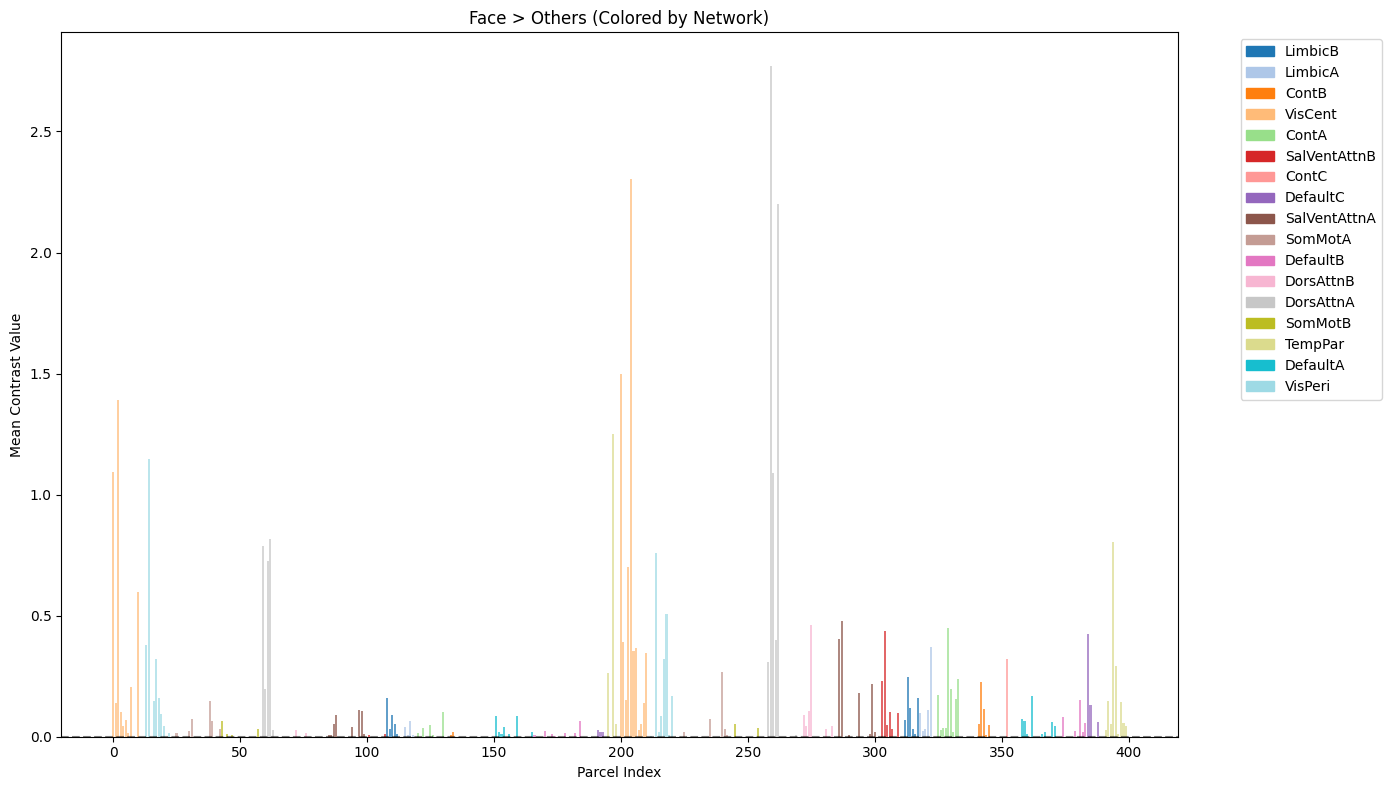

In [25]:
# Create color map for networks
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_networks)))
network_color_map = dict(zip(unique_networks, colors))
bar_colors = [network_color_map[net] for net in networks]

# Improved visualization
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(range(400), parcel_values, color=bar_colors, alpha=0.7)
ax.set_title('Face > Others (Colored by Network)')
ax.set_xlabel('Parcel Index')
ax.set_ylabel('Mean Contrast Value')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Add legend for networks 
handles = [plt.Rectangle((0,0),1,1, color=network_color_map[net]) for net in unique_networks]
ax.legend(handles, unique_networks, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

#### Analyze and visualize top 10 face-selective Parcels

In [26]:
# Simplify labels for better readability
def simplify_label(label):
    """Simplify Schaefer labels for display"""
    try:
        # Remove '17Networks_' prefix and make more readable
        parts = label.replace('17Networks_', '').split('_')
        hemisphere = parts[0]  # LH or RH
        network = parts[1]     # Network name
        region = '_'.join(parts[2:])  # Region description
        return f"{hemisphere} {network}\n{region}"
    except:
        return label

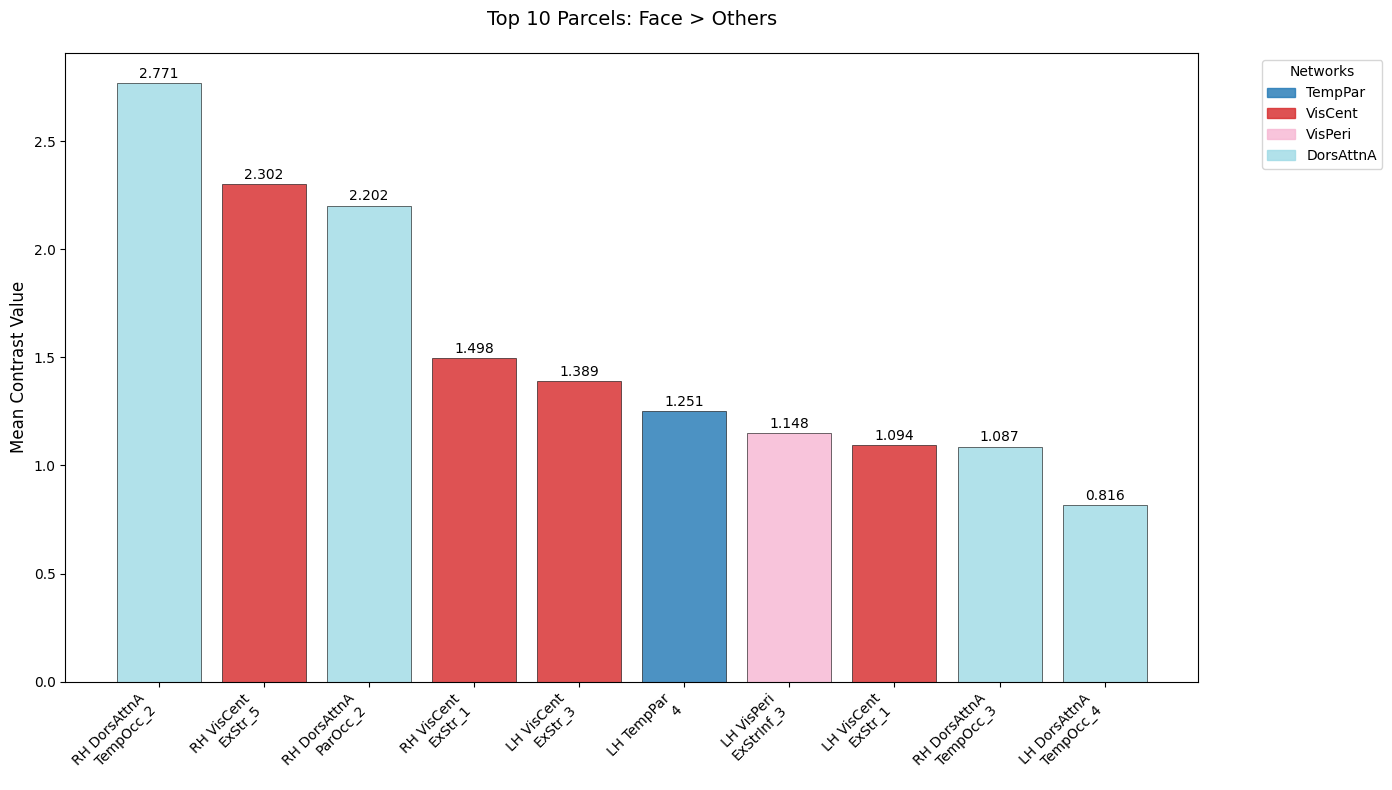


Top 10 Face-Selective Parcels:
------------------------------------------------------------
 1. 17Networks_RH_DorsAttnA_TempOcc_2        |  2.771 | DorsAttnA
 2. 17Networks_RH_VisCent_ExStr_5            |  2.302 | VisCent
 3. 17Networks_RH_DorsAttnA_ParOcc_2         |  2.202 | DorsAttnA
 4. 17Networks_RH_VisCent_ExStr_1            |  1.498 | VisCent
 5. 17Networks_LH_VisCent_ExStr_3            |  1.389 | VisCent
 6. 17Networks_LH_TempPar_4                  |  1.251 | TempPar
 7. 17Networks_LH_VisPeri_ExStrInf_3         |  1.148 | VisPeri
 8. 17Networks_LH_VisCent_ExStr_1            |  1.094 | VisCent
 9. 17Networks_RH_DorsAttnA_TempOcc_3        |  1.087 | DorsAttnA
10. 17Networks_LH_DorsAttnA_TempOcc_4        |  0.816 | DorsAttnA


In [27]:
top_n = 10
sorted_indices = np.argsort(parcel_values)[::-1]
top_indices = sorted_indices[:top_n]
top_labels = [get_parcel_name(i, df_labels) for i in top_indices]
top_values = parcel_values[top_indices]

# Extract networks for color coding
top_networks = [extract_network(label) for label in top_labels]
unique_top_networks = list(set(top_networks))
network_color_map = dict(zip(unique_top_networks, plt.cm.tab20(np.linspace(0, 1, len(unique_top_networks)))))
bar_colors = [network_color_map[net] for net in top_networks]

# Get simplified labels
simple_labels = [simplify_label(label) for label in top_labels]

# Visualize top 10 face-selective parcels
plt.figure(figsize=(14, 8))
bars = plt.bar(range(top_n), top_values, color=bar_colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, top_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontsize=10)

plt.xticks(range(top_n), simple_labels, rotation=45, ha='right', fontsize=10)
plt.ylabel("Mean Contrast Value", fontsize=12)
plt.title("Top 10 Parcels: Face > Others", fontsize=14, pad=20)

# Add network legend
handles = [plt.Rectangle((0,0),1,1, color=network_color_map[net], alpha=0.8) for net in unique_top_networks]
plt.legend(handles, unique_top_networks, title='Networks', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Print summary table
print("\nTop 10 Face-Selective Parcels:")
print("-" * 60)
for i, (label, value, network) in enumerate(zip(top_labels, top_values, top_networks), 1):
    print(f"{i:2d}. {label:<40} | {value:6.3f} | {network}")

#### Dependencies in Jupyter/Python
- Using the package [watermark](https://github.com/rasbt/watermark) to document system environment and software versions used in this notebook

In [28]:
%load_ext watermark

%watermark
%watermark --iversions

Last updated: 2025-11-02T23:44:19.884530+00:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.4.0-204-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

matplotlib      : 3.8.4
nibabel         : 5.3.2
numpy           : 2.2.6
nilearn         : 0.12.0
re              : 2.2.1
niwrap_workbench: 0.6.1
pandas          : 2.2.3

